# Lets do a case study on marketing attribution using Regression

> Today’s marketers rely on multi-channel strategies to carry out marketing campaigns, both online and offline. While this practice enables marketers to customize the customer journey along every step, it also presents unique challenges once it’s time to analyze the overall impact of a particular campaign on marketing ROI.

## What is Marketing Attribution?
> To put simply, marketing attribution is the analytical science of determining which marketing tactics are contributing to sales or conversions.

> Marketing attribution is the practice of evaluating the marketing touchpoints a consumer encounters on their path to purchase. The goal of attribution is to determine which channels and messages had the greatest impact on the decision to convert, or take the desired next step. There are several popular attribution models used by marketers today, such as multi-touch attribution, lift studies, time decay, and more. The insights provided by these models into how, where, and when a consumer interacts with brand messages allows marketing teams to alter and customize campaigns to meet the specific desires of individual consumers, thus improving marketing ROI.

Rule based attribution models:

* Rule based marketing attribution models do not take the data into consideration but attribution is done based on few rules, below is the example 

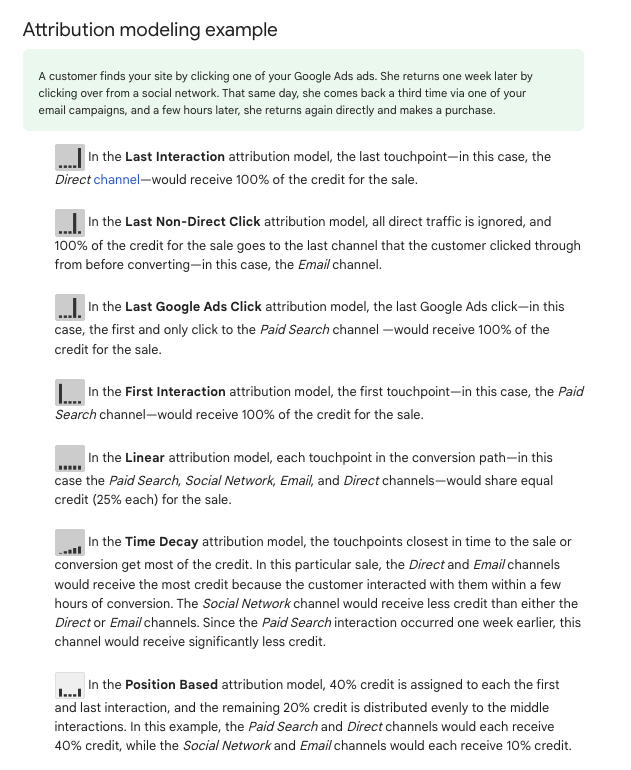

Data Driven Models:

* We can use Machine leraning models as data driven models for market attribution.
* below is the case study for regression based mix marketing model 

Import Section


In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sks
from sklearn.datasets import load_boston
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,median_absolute_error,mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector 
from sklearn.linear_model import Lasso,ElasticNet,Ridge
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

### lets pull advertising and sales data for case study

In [5]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir marketingdata
! kaggle datasets download -d sazid28/advertising.csv
!unzip advertising.csv.zip -d marketingdata

Saving kaggle.json to kaggle (1).json
advertising.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  advertising.csv.zip
  inflating: marketingdata/Advertising.csv  


# <center> Lets perform some EDA (Exploratory Data Analysis)</center>

In [9]:
dataset = pd.read_csv('/content/marketingdata/Advertising.csv')
dataset = dataset.drop('Unnamed: 0',axis = 1)
dataset.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [11]:
dataset.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


Note: Here we have three channels namely TV,Radio and New paper data
* TV,Radio and New paper monthly spends  on the adds of a particular product
* monthly sales data of that product.



#### Lets see how they are corrletaed

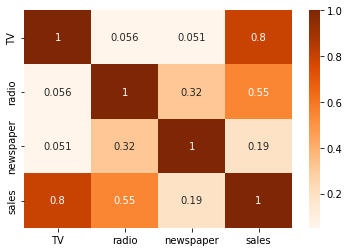

In [15]:
sns.heatmap(dataset.corr(method='spearman'),annot = True, cmap = 'Oranges')

Observations: Using Spearman rank Correlation we can say that sales are more correlated with TV , than Radio and News Papers

### Univariate Analysis

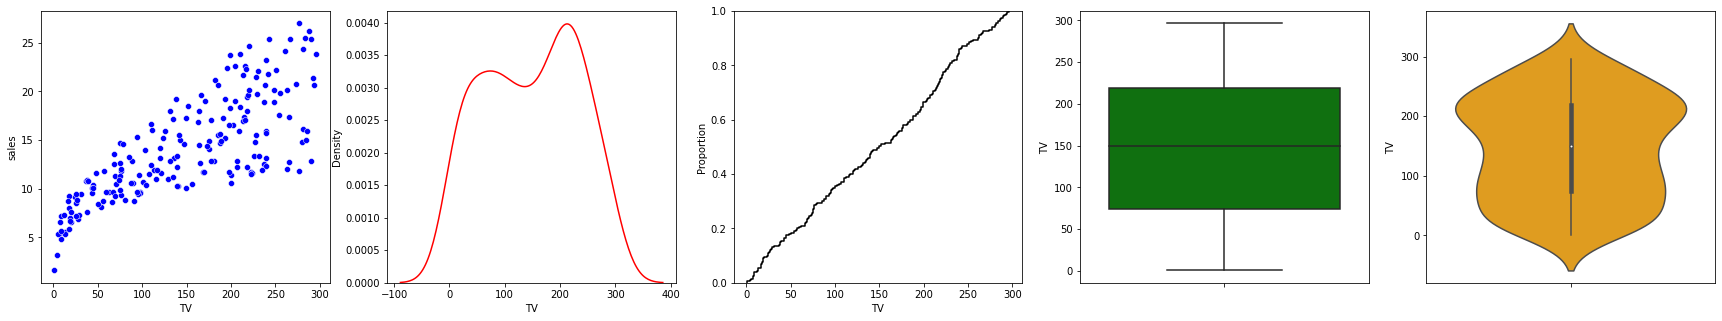

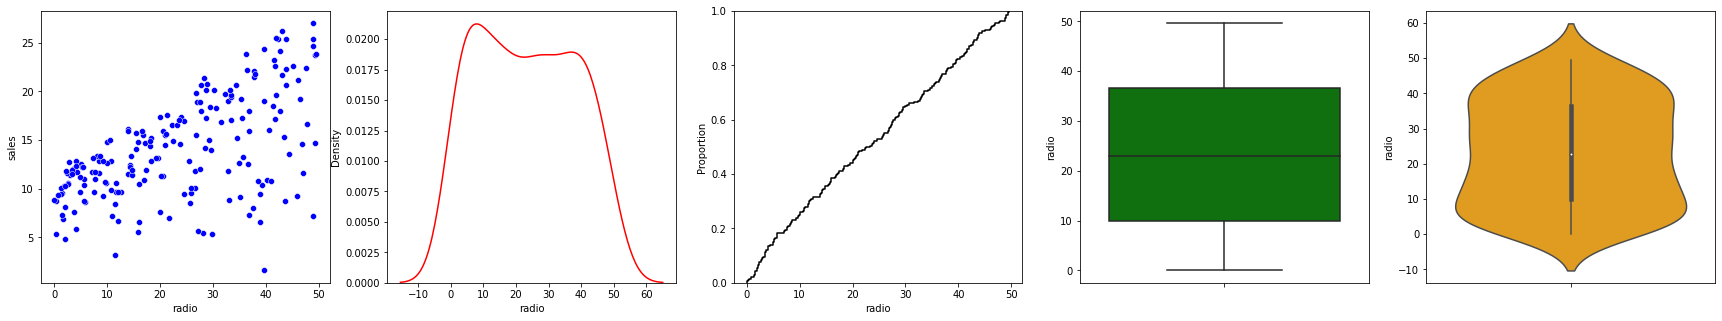

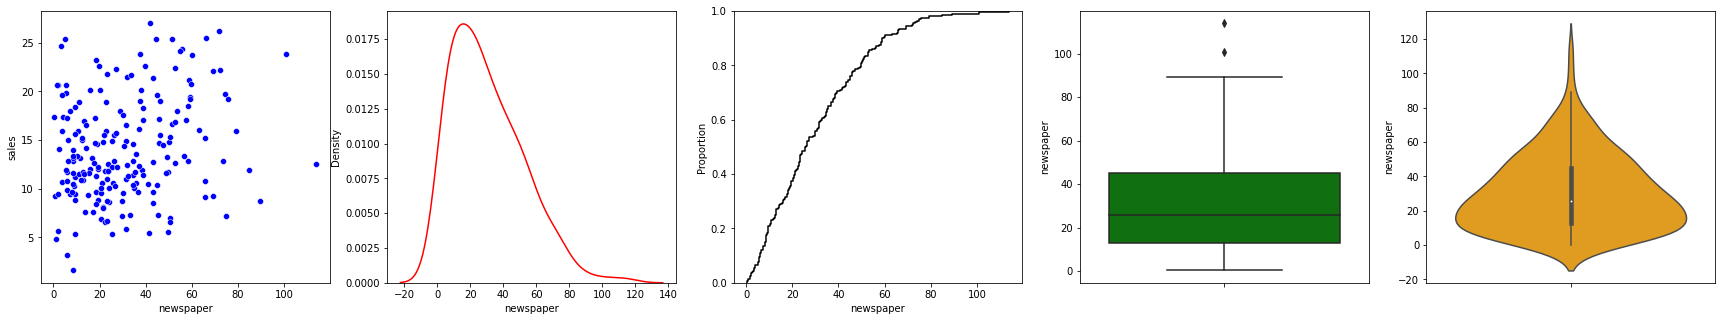

In [52]:
for column in dataset.columns[:-1]:
  fig, axs = plt.subplots(ncols=5)
  fig.set_size_inches(30,5)
  sns.scatterplot(data=dataset, x=column, y="sales", ax=axs[0],color = 'blue')
  sns.kdeplot(data=dataset, x=column,ax=axs[1],color = 'red')
  sns.ecdfplot(data=dataset, x=column, ax=axs[2],color = 'black')
  sns.boxplot(data=dataset, y=column,orient="v", ax=axs[3],color = 'green')
  sns.violinplot(data=dataset, y=column,orient="v", ax=axs[4],color = 'orange')
  fig.show()


Observations:

* Tv spend with sales have some linear trend, and radio and newspaper have like random spread.
* mean spend on tv is higher compared to other channels.
* newspaper is skewed towards left hence have more lower spends compared to other channels.
* none of the distributions are gaussian.


### Lets do bi variate analysis

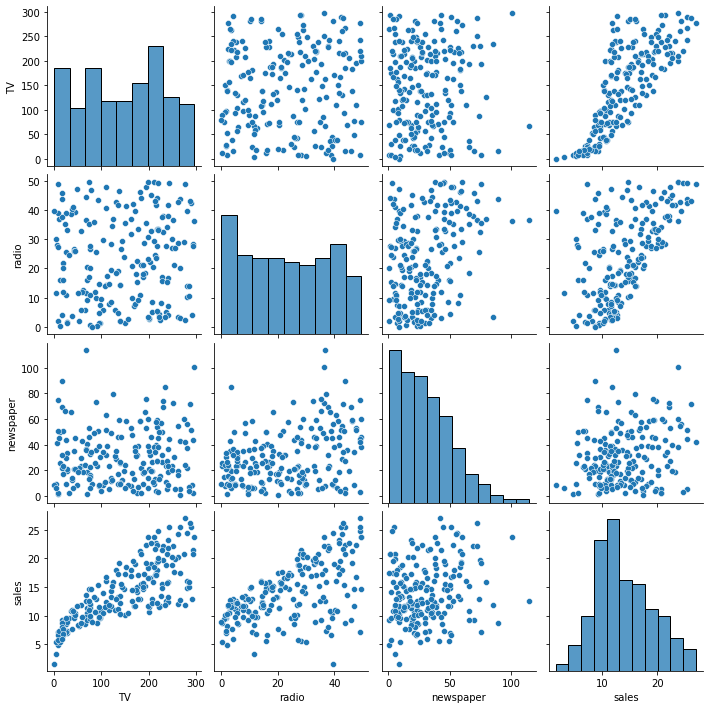

In [55]:
#sns.pairplot(dataset[:])

Observations:
* we can get same intuition we got from the above plots.

# <center> let do some Pre Processing</Center>

### Null value analysis

In [57]:
dataset.isnull().sum()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

observations: 
* No null values in the data
* All features are continuos but in different scale

### split to train and test data


In [62]:
X = dataset.drop('sales',axis = 1)
y = dataset[['sales']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.20)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(160, 3)
(40, 3)
(160, 1)
(40, 1)


### Standardization of the data

In [63]:
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)


### lets create a result set for result analysis

In [65]:
result_dataset = pd.DataFrame(data =np.zeros((6,9)) , index = ['r2_score','adjusted_r2_score','median_absolute_error','mean_squared_error','mean_absolute_percentage_error','mean_absolute_error'],columns = ['linear_regression','polynomial_linear_regression','lasso_regression','ridge_regression','elasticnet_regression','SVR','Decision_Tree','Random_Forest','LightGBM'])
result_dataset

,linear_regression,polynomial_linear_regression,lasso_regression,ridge_regression,elasticnet_regression,SVR,Decision_Tree,Random_Forest,LightGBM
r2_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
def metrics(y_true,y_pred,model = 'linear_regression'):
  r2_scores = r2_score(y_true,y_pred)
  p = 13 # number of features in the test dataset
  adjusted_r2_scores = 1- (1- r2_score(y_true,y_pred))*(len(y_true)-1)/(len(y_true)-p-1)
  median_absolute_errors = median_absolute_error(y_true,y_pred)
  mean_squared_errors = mean_squared_error(y_true,y_pred)
  mean_absolute_percentage_errors = mean_absolute_percentage_error(y_true,y_pred)
  mean_absolute_errors = mean_absolute_error(y_true,y_pred)
  result_dataset[model]['r2_score'] = r2_scores
  result_dataset[model]['adjusted_r2_score'] = adjusted_r2_scores
  result_dataset[model]['median_absolute_error'] = median_absolute_errors
  result_dataset[model]['mean_squared_error'] = mean_squared_errors
  result_dataset[model]['mean_absolute_percentage_error'] = mean_absolute_percentage_errors
  result_dataset[model]['mean_absolute_error'] = mean_absolute_errors
  print('r2_score for '+ model + " :" + str(r2_scores))
  print('adjusted_r2_score for '+ model + " :" + str(adjusted_r2_scores)) # Adj r2 = 1-(1-R2)*(n-1)/(n-p-1) Where n is the sample size and p is the number of independent variables.
  print('median_absolute_error for '+ model + " :" + str(median_absolute_errors))
  print('mean_squared_error for '+ model + " :" + str(mean_squared_errors))
  print('mean_absolute_percentage_error for '+ model + " :" + str(mean_absolute_percentage_errors))
  print('mean_absolute_error for '+ model + " :" + str(mean_absolute_errors))



### lets apply simple linear regression

In [70]:
linear_reg = LinearRegression()
param_grids = {}
linear_reg = GridSearchCV(estimator = linear_reg,param_grid = param_grids,cv = 5, scoring = 'neg_median_absolute_error',verbose = 2)
linear_reg.fit(X_train,y_train)
linear_reg.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


LinearRegression()

LinearRegression()

In [71]:
linear_reg = LinearRegression()
linear_reg.fit(X_train,y_train)

LinearRegression()

In [72]:
y_pred = linear_reg.predict(X_test)
metrics(y_test,y_pred,model = 'linear_regression')
result_dataset

r2_score for linear_regression :0.9190338057438134
adjusted_r2_score for linear_regression :0.8785507086157202
median_absolute_error for linear_regression :1.152448713627423
mean_squared_error for linear_regression :2.5998320881468615
mean_absolute_percentage_error for linear_regression :0.149570751921122
mean_absolute_error for linear_regression :1.3082303945930616


,linear_regression,polynomial_linear_regression,lasso_regression,ridge_regression,elasticnet_regression,SVR,Decision_Tree,Random_Forest,LightGBM
r2_score,0.919034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.878551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,1.152449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,2.599832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.149571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,1.308230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lets Interpret the model

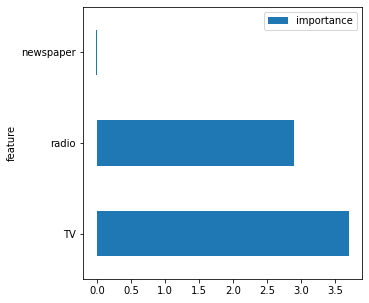

In [93]:
pd.DataFrame(data = zip(list(X.columns),list(linear_reg.coef_)[0]), columns = ['feature','importance']).plot.barh(y = 'importance',x= 'feature',figsize=(5,5),align = 'center')

In [97]:
print(linear_reg.coef_)
print(linear_reg.intercept_)

[[ 3.7043821   2.89643872 -0.02232748]]
[14.30625]


observations:
Equation we get is sales = (3.7043821 * TV) + (2.89643872 * radio) - (0.02232748 * newspaper) + 14.30625 + (error(which linear model cannot reduce)
* hence when we do not spend any money on advertisement then approximately we will get 14 units of sales.
* how trust worthy is this , it depends on how multicolinear these features are if they are multi colinear , which they are it is not accurate feature importances.
* later in this case study we will see model agnostic feature importance techniques like LIME and SHAP which give better feature importances.

# lets apply ploynomial regression

In [99]:
polynomial = PolynomialFeatures()
X_train_poly = polynomial.fit_transform(X_train)
X_test_poly =  polynomial.transform(X_test) 
print(X_train.shape)
print(X_train_poly.shape)
print(X_test.shape)
print(X_test_poly.shape)

(160, 3)
(160, 10)
(40, 3)
(40, 10)


In [101]:
poly_linear_reg = LinearRegression()
param_grids = {}
poly_linear_reg = GridSearchCV(estimator = poly_linear_reg,param_grid = param_grids,cv = 5, scoring = 'neg_median_absolute_error',verbose = 2)
poly_linear_reg.fit(X_train_poly,y_train)
poly_linear_reg.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


LinearRegression()

In [103]:
poly_linear_reg = LinearRegression()
poly_linear_reg.fit(X_train_poly,y_train)
y_pred = poly_linear_reg.predict(X_test_poly)
metrics(y_test,y_pred,model = 'polynomial_linear_regression')
result_dataset

r2_score for polynomial_linear_regression :0.9831797149310906
adjusted_r2_score for polynomial_linear_regression :0.9747695723966359
median_absolute_error for polynomial_linear_regression :0.3718126863636533
mean_squared_error for polynomial_linear_regression :0.5401009304644081
mean_absolute_percentage_error for polynomial_linear_regression :0.07170950448403253
mean_absolute_error for polynomial_linear_regression :0.5168029055111807


,linear_regression,polynomial_linear_regression,lasso_regression,ridge_regression,elasticnet_regression,SVR,Decision_Tree,Random_Forest,LightGBM
r2_score,0.919034,0.983180,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.878551,0.974770,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,1.152449,0.371813,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,2.599832,0.540101,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.149571,0.071710,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,1.308230,0.516803,0.0,0.0,0.0,0.0,0.0,0.0,0.0


observations:
* when we transformed the 3 features into 10 features we have very good performance.

In [109]:
list(polynomial.get_feature_names_out(input_features = list(X.columns)))

['1',
 'TV',
 'radio',
 'newspaper',
 'TV^2',
 'TV radio',
 'TV newspaper',
 'radio^2',
 'radio newspaper',
 'newspaper^2']

#### Lets Interpret the model

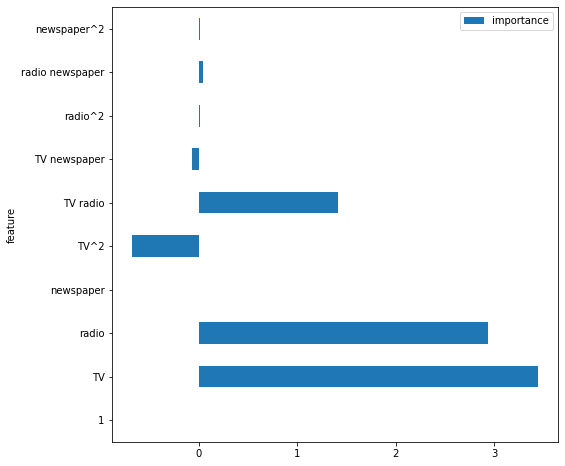

In [119]:
pd.DataFrame(data = zip(list(list(polynomial.get_feature_names_out(input_features = list(X.columns)))),list(poly_linear_reg.coef_)[0]), columns = ['feature','importance']).plot.barh(y = 'importance',x= 'feature',figsize=(8,8),align = 'center')

In [114]:
print(poly_linear_reg.coef_)
print(poly_linear_reg.intercept_)

[[ 0.          3.43845847  2.93339363  0.00644077 -0.6769755   1.41765291
  -0.06384549  0.01245065  0.04636517  0.01502485]]
[14.90645609]


### lets apply lasso Regression with polynomial features

In [115]:
lasso_reg = Lasso(random_state = 42)
param_grids = {'alpha' : [0.0001, 0.001, 0.00001,0.1,0.01]}
lasso_reg = GridSearchCV(estimator = lasso_reg,param_grid = param_grids,cv = 5, scoring = 'neg_median_absolute_error',verbose = 2)
lasso_reg.fit(X_train_poly,y_train)
lasso_reg.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................

Lasso(alpha=0.01, random_state=42)

In [116]:
lasso_reg =  Lasso(random_state = 42,alpha = 0.01)
lasso_reg.fit(X_train_poly,y_train)
y_pred = lasso_reg.predict(X_test_poly)
metrics(y_test,y_pred,model = 'lasso_regression')
result_dataset

r2_score for lasso_regression :0.9827351378450628
adjusted_r2_score for lasso_regression :0.9741027067675943
median_absolute_error for lasso_regression :0.34459334280231335
mean_squared_error for lasso_regression :0.5543763423758596
mean_absolute_percentage_error for lasso_regression :0.0724871765295666
mean_absolute_error for lasso_regression :0.5168382652581376


,linear_regression,polynomial_linear_regression,lasso_regression,ridge_regression,elasticnet_regression,SVR,Decision_Tree,Random_Forest,LightGBM
r2_score,0.919034,0.983180,0.982735,0.0,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.878551,0.974770,0.974103,0.0,0.0,0.0,0.0,0.0,0.0
median_absolute_error,1.152449,0.371813,0.344593,0.0,0.0,0.0,0.0,0.0,0.0
mean_squared_error,2.599832,0.540101,0.554376,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.149571,0.071710,0.072487,0.0,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,1.308230,0.516803,0.516838,0.0,0.0,0.0,0.0,0.0,0.0


#### Lets Interpret the model

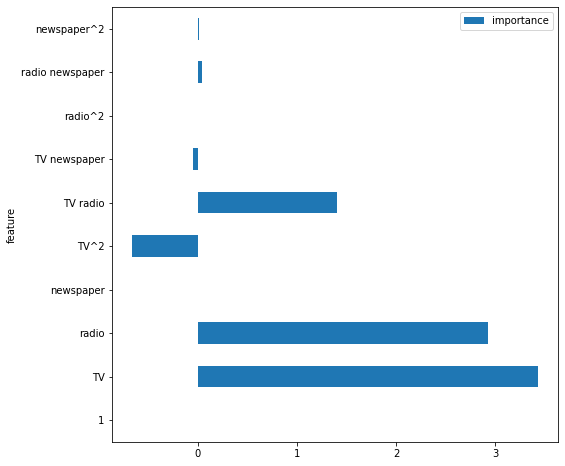

In [127]:
pd.DataFrame(data = zip(list(list(polynomial.get_feature_names_out(input_features = list(X.columns)))),list(lasso_reg.coef_)), columns = ['feature','importance']).plot.barh(y = 'importance',x= 'feature',figsize=(8,8),align = 'center')

### lets apply Ridge Regression with polynomial features

In [128]:
ridge_reg = Ridge(random_state = 42)
param_grids = {'alpha' : [0.0001, 0.001, 0.00001,0.1,0.01]}
ridge_reg = GridSearchCV(estimator = ridge_reg,param_grid = param_grids,cv = 5, scoring = 'neg_median_absolute_error',verbose = 2)
ridge_reg.fit(X_train_poly,y_train)
ridge_reg.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END .......................................alpha=0.0001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=1e-05; total time=   0.0s
[CV] END ........................................

Ridge(alpha=0.1, random_state=42)

In [129]:
ridge_reg =  Ridge(random_state = 42,alpha = 0.1)
ridge_reg.fit(X_train_poly,y_train)
y_pred = ridge_reg.predict(X_test_poly)
metrics(y_test,y_pred,model = 'ridge_regression')
result_dataset

r2_score for ridge_regression :0.9831458399858076
adjusted_r2_score for ridge_regression :0.9747187599787115
median_absolute_error for ridge_regression :0.3718012138038729
mean_squared_error for ridge_regression :0.5411886581332181
mean_absolute_percentage_error for ridge_regression :0.0718107653476188
mean_absolute_error for ridge_regression :0.5173714314254381


,linear_regression,polynomial_linear_regression,lasso_regression,ridge_regression,elasticnet_regression,SVR,Decision_Tree,Random_Forest,LightGBM
r2_score,0.919034,0.983180,0.982735,0.983146,0.0,0.0,0.0,0.0,0.0
adjusted_r2_score,0.878551,0.974770,0.974103,0.974719,0.0,0.0,0.0,0.0,0.0
median_absolute_error,1.152449,0.371813,0.344593,0.371801,0.0,0.0,0.0,0.0,0.0
mean_squared_error,2.599832,0.540101,0.554376,0.541189,0.0,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.149571,0.071710,0.072487,0.071811,0.0,0.0,0.0,0.0,0.0
mean_absolute_error,1.308230,0.516803,0.516838,0.517371,0.0,0.0,0.0,0.0,0.0


#### Lets Interpret the model

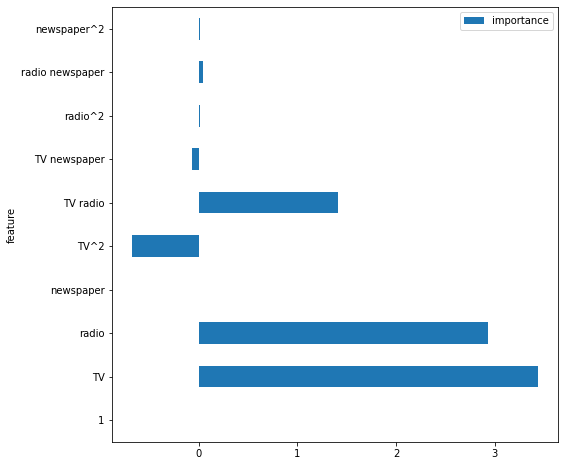

In [133]:
pd.DataFrame(data = zip(list(list(polynomial.get_feature_names_out(input_features = list(X.columns)))),list(ridge_reg.coef_[0])), columns = ['feature','importance']).plot.barh(y = 'importance',x= 'feature',figsize=(8,8),align = 'center')

### lets apply Elaticnet Regression with polynomial features

In [135]:
elastic_reg = ElasticNet(random_state = 42)
param_grids = {'alpha' : [1.0,0.001,0.1,0.01],'l1_ratio' : [0.1,0.4,0.7,0.9]}
elastic_reg = GridSearchCV(estimator = elastic_reg,param_grid = param_grids,cv = 5, scoring = 'neg_median_absolute_error',verbose = 2)
elastic_reg.fit(X_train_poly,y_train)
elastic_reg.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ............................alpha=1.0, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=1.0, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=1.0, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=1.0, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=1.0, l1_ratio=0.1; total time=   0.0s
[CV] END ............................alpha=1.0, l1_ratio=0.4; total time=   0.0s
[CV] END ............................alpha=1.0, l1_ratio=0.4; total time=   0.0s
[CV] END ............................alpha=1.0, l1_ratio=0.4; total time=   0.0s
[CV] END ............................alpha=1.0, l1_ratio=0.4; total time=   0.0s
[CV] END ............................alpha=1.0, l1_ratio=0.4; total time=   0.0s
[CV] END ............................alpha=1.0, l1_ratio=0.7; total time=   0.0s
[CV] END ............................alpha=1.0, 

ElasticNet(alpha=0.01, l1_ratio=0.9, random_state=42)

In [136]:
elastic_reg =  ElasticNet(random_state = 42,alpha = 0.01,l1_ratio=0.9)
elastic_reg.fit(X_train_poly,y_train)
y_pred = elastic_reg.predict(X_test_poly)
metrics(y_test,y_pred,model = 'elasticnet_regression')
result_dataset

r2_score for elasticnet_regression :0.9827197085172078
adjusted_r2_score for elasticnet_regression :0.9740795627758116
median_absolute_error for elasticnet_regression :0.34796045566069456
mean_squared_error for elasticnet_regression :0.5548717795397842
mean_absolute_percentage_error for elasticnet_regression :0.07257705098811187
mean_absolute_error for elasticnet_regression :0.5177611675621829


,linear_regression,polynomial_linear_regression,lasso_regression,ridge_regression,elasticnet_regression,SVR,Decision_Tree,Random_Forest,LightGBM
r2_score,0.919034,0.983180,0.982735,0.983146,0.982720,0.0,0.0,0.0,0.0
adjusted_r2_score,0.878551,0.974770,0.974103,0.974719,0.974080,0.0,0.0,0.0,0.0
median_absolute_error,1.152449,0.371813,0.344593,0.371801,0.347960,0.0,0.0,0.0,0.0
mean_squared_error,2.599832,0.540101,0.554376,0.541189,0.554872,0.0,0.0,0.0,0.0
mean_absolute_percentage_error,0.149571,0.071710,0.072487,0.071811,0.072577,0.0,0.0,0.0,0.0
mean_absolute_error,1.308230,0.516803,0.516838,0.517371,0.517761,0.0,0.0,0.0,0.0


#### Lets Interpret the model

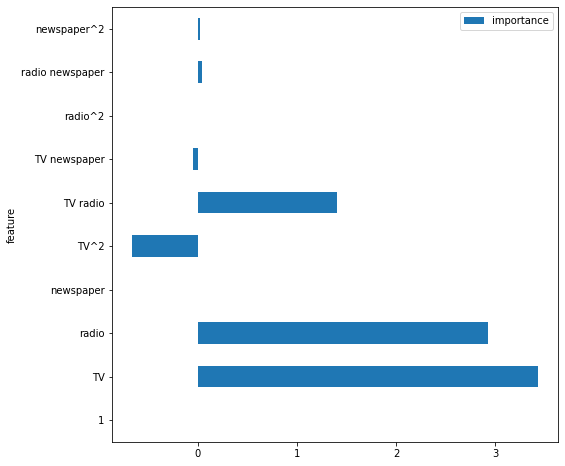

In [138]:
pd.DataFrame(data = zip(list(list(polynomial.get_feature_names_out(input_features = list(X.columns)))),list(elastic_reg.coef_)), columns = ['feature','importance']).plot.barh(y = 'importance',x= 'feature',figsize=(8,8),align = 'center')

### lets implement Support Vector regression
> As suppport vector regressors have kernal trick and hence we are not using ploynomial features , but using kernals to transform featres

In [145]:
svr_reg = SVR()
param_grids = {'C' : [1.0,0.001,0.1,0.01],'kernel' : ['linear','poly','rbf','sigmoid'],'degree' : [2,3,4]}
svr_reg = GridSearchCV(estimator = svr_reg,param_grid = param_grids,cv = 5, scoring = 'neg_median_absolute_error',verbose = 2)
svr_reg.fit(X_train,y_train)
svr_reg.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .....................C=1.0, degree=2, kernel=linear; total time=   0.0s
[CV] END .....................C=1.0, degree=2, kernel=linear; total time=   0.0s
[CV] END .....................C=1.0, degree=2, kernel=linear; total time=   0.0s
[CV] END .....................C=1.0, degree=2, kernel=linear; total time=   0.0s
[CV] END .....................C=1.0, degree=2, kernel=linear; total time=   0.0s
[CV] END .......................C=1.0, degree=2, kernel=poly; total time=   0.0s
[CV] END .......................C=1.0, degree=2, kernel=poly; total time=   0.0s
[CV] END .......................C=1.0, degree=2, kernel=poly; total time=   0.0s
[CV] END .......................C=1.0, degree=2, kernel=poly; total time=   0.0s
[CV] END .......................C=1.0, degree=2, kernel=poly; total time=   0.0s
[CV] END ........................C=1.0, degree=2, kernel=rbf; total time=   0.0s
[CV] END ........................C=1.0, degree=

SVR(degree=2)

In [146]:
svr_reg.best_params_

{'C': 1.0, 'degree': 2, 'kernel': 'rbf'}

In [150]:
svr_reg =  SVR(C = 1.0, kernel = 'rbf',degree=2)
svr_reg.fit(X_train,y_train)
y_pred = svr_reg.predict(X_test)
metrics(y_test,y_pred,model = 'SVR')
result_dataset

r2_score for SVR :0.8617470073604143
adjusted_r2_score for SVR :0.7926205110406215
median_absolute_error for SVR :0.6292455325530897
mean_squared_error for SVR :4.439316554875154
mean_absolute_percentage_error for SVR :0.16936895938081226
mean_absolute_error for SVR :1.321750422262324


,linear_regression,polynomial_linear_regression,lasso_regression,ridge_regression,elasticnet_regression,SVR,Decision_Tree,Random_Forest,LightGBM
r2_score,0.919034,0.983180,0.982735,0.983146,0.982720,0.861747,0.0,0.0,0.0
adjusted_r2_score,0.878551,0.974770,0.974103,0.974719,0.974080,0.792621,0.0,0.0,0.0
median_absolute_error,1.152449,0.371813,0.344593,0.371801,0.347960,0.629246,0.0,0.0,0.0
mean_squared_error,2.599832,0.540101,0.554376,0.541189,0.554872,4.439317,0.0,0.0,0.0
mean_absolute_percentage_error,0.149571,0.071710,0.072487,0.071811,0.072577,0.169369,0.0,0.0,0.0
mean_absolute_error,1.308230,0.516803,0.516838,0.517371,0.517761,1.321750,0.0,0.0,0.0


### lets implement Decision Tree Regression

In [160]:
dt_reg = DecisionTreeRegressor()
ccp_alphas = dt_reg.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']
param_grids = {'max_depth' : [22,25,27,30,35,38],'ccp_alpha': np.random.choice(ccp_alphas,size=30)}
dt_reg = GridSearchCV(estimator = dt_reg,param_grid = param_grids,cv = 5, scoring = 'neg_median_absolute_error',verbose = 2)
dt_reg.fit(X_train_poly,y_train)
dt_reg.best_estimator_

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END ......ccp_alpha=0.0005000000000002558, max_depth=22; total time=   0.0s
[CV] END ......ccp_alpha=0.0005000000000002558, max_depth=22; total time=   0.0s
[CV] END ......ccp_alpha=0.0005000000000002558, max_depth=22; total time=   0.0s
[CV] END ......ccp_alpha=0.0005000000000002558, max_depth=22; total time=   0.0s
[CV] END ......ccp_alpha=0.0005000000000002558, max_depth=22; total time=   0.0s
[CV] END ......ccp_alpha=0.0005000000000002558, max_depth=25; total time=   0.0s
[CV] END ......ccp_alpha=0.0005000000000002558, max_depth=25; total time=   0.0s
[CV] END ......ccp_alpha=0.0005000000000002558, max_depth=25; total time=   0.0s
[CV] END ......ccp_alpha=0.0005000000000002558, max_depth=25; total time=   0.0s
[CV] END ......ccp_alpha=0.0005000000000002558, max_depth=25; total time=   0.0s
[CV] END ......ccp_alpha=0.0005000000000002558, max_depth=27; total time=   0.0s
[CV] END ......ccp_alpha=0.0005000000000002558

DecisionTreeRegressor(ccp_alpha=0.0005104166666669129, max_depth=25)

In [161]:
dt_reg =  DecisionTreeRegressor(ccp_alpha=0.0005104166666669129, max_depth=25)
dt_reg.fit(X_train_poly,y_train)
y_pred = dt_reg.predict(X_test_poly)
metrics(y_test,y_pred,model = 'Decision_Tree')
result_dataset

r2_score for Decision_Tree :0.9354219354051767
adjusted_r2_score for Decision_Tree :0.9031329031077651
median_absolute_error for Decision_Tree :0.841666666666665
mean_squared_error for Decision_Tree :2.0736077083333333
mean_absolute_percentage_error for Decision_Tree :0.12949892612619734
mean_absolute_error for Decision_Tree :1.104958333333333


,linear_regression,polynomial_linear_regression,lasso_regression,ridge_regression,elasticnet_regression,SVR,Decision_Tree,Random_Forest,LightGBM
r2_score,0.919034,0.983180,0.982735,0.983146,0.982720,0.861747,0.935422,0.0,0.0
adjusted_r2_score,0.878551,0.974770,0.974103,0.974719,0.974080,0.792621,0.903133,0.0,0.0
median_absolute_error,1.152449,0.371813,0.344593,0.371801,0.347960,0.629246,0.841667,0.0,0.0
mean_squared_error,2.599832,0.540101,0.554376,0.541189,0.554872,4.439317,2.073608,0.0,0.0
mean_absolute_percentage_error,0.149571,0.071710,0.072487,0.071811,0.072577,0.169369,0.129499,0.0,0.0
mean_absolute_error,1.308230,0.516803,0.516838,0.517371,0.517761,1.321750,1.104958,0.0,0.0


#### Lets Interpret the model

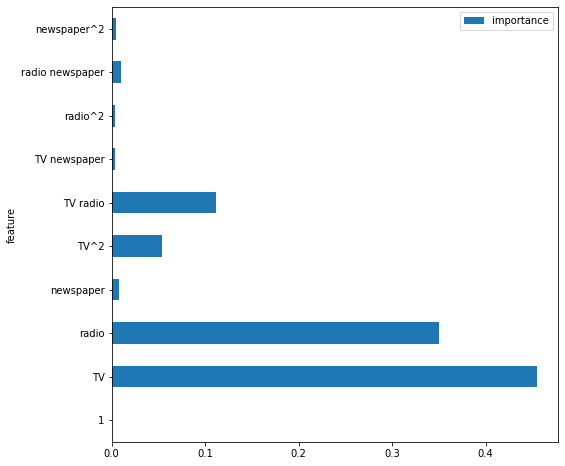

In [172]:
pd.DataFrame(data = zip(list(list(polynomial.get_feature_names_out(input_features = list(X.columns)))),list(dt_reg.feature_importances_)), columns = ['feature','importance']).plot.barh(y = 'importance',x= 'feature',figsize=(8,8),align = 'center')

### now lets apply random_forest(bagging)

In [165]:
rf_reg = RandomForestRegressor()
param_grids = {'n_estimators' : [25,50,75,100,125,150],'criterion' : ['squared_error', 'absolute_error'],'max_depth' : [45,50,60,70]}
rf_reg = GridSearchCV(estimator = rf_reg,param_grid = param_grids,cv = 5, scoring = 'neg_median_absolute_error', verbose = 2)
rf_reg.fit(X_train_poly,y_train)
rf_reg.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END criterion=squared_error, max_depth=45, n_estimators=25; total time=   0.1s
[CV] END criterion=squared_error, max_depth=45, n_estimators=25; total time=   0.0s
[CV] END criterion=squared_error, max_depth=45, n_estimators=25; total time=   0.0s
[CV] END criterion=squared_error, max_depth=45, n_estimators=25; total time=   0.0s
[CV] END criterion=squared_error, max_depth=45, n_estimators=25; total time=   0.0s
[CV] END criterion=squared_error, max_depth=45, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=45, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=45, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=45, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=45, n_estimators=50; total time=   0.1s
[CV] END criterion=squared_error, max_depth=45, n_estimators=75; total time=   0.1s
[CV] END crite

RandomForestRegressor(max_depth=50, n_estimators=75)

In [166]:
rf_reg.best_params_

{'criterion': 'squared_error', 'max_depth': 50, 'n_estimators': 75}

In [168]:
rf_reg =  RandomForestRegressor(max_depth=50, n_estimators=75,criterion = 'squared_error')
rf_reg.fit(X_train_poly,y_train)
y_pred = rf_reg.predict(X_test_poly)
metrics(y_test,y_pred,model = 'Random_Forest')
result_dataset

r2_score for Random_Forest :0.9792118438008471
adjusted_r2_score for Random_Forest :0.9688177657012707
median_absolute_error for Random_Forest :0.5619999999999941
mean_squared_error for Random_Forest :0.6675096444444426
mean_absolute_percentage_error for Random_Forest :0.07078658395605184
mean_absolute_error for Random_Forest :0.6620999999999997


,linear_regression,polynomial_linear_regression,lasso_regression,ridge_regression,elasticnet_regression,SVR,Decision_Tree,Random_Forest,LightGBM
r2_score,0.919034,0.983180,0.982735,0.983146,0.982720,0.861747,0.935422,0.979212,0.0
adjusted_r2_score,0.878551,0.974770,0.974103,0.974719,0.974080,0.792621,0.903133,0.968818,0.0
median_absolute_error,1.152449,0.371813,0.344593,0.371801,0.347960,0.629246,0.841667,0.562000,0.0
mean_squared_error,2.599832,0.540101,0.554376,0.541189,0.554872,4.439317,2.073608,0.667510,0.0
mean_absolute_percentage_error,0.149571,0.071710,0.072487,0.071811,0.072577,0.169369,0.129499,0.070787,0.0
mean_absolute_error,1.308230,0.516803,0.516838,0.517371,0.517761,1.321750,1.104958,0.662100,0.0


#### Lets Interpret the model

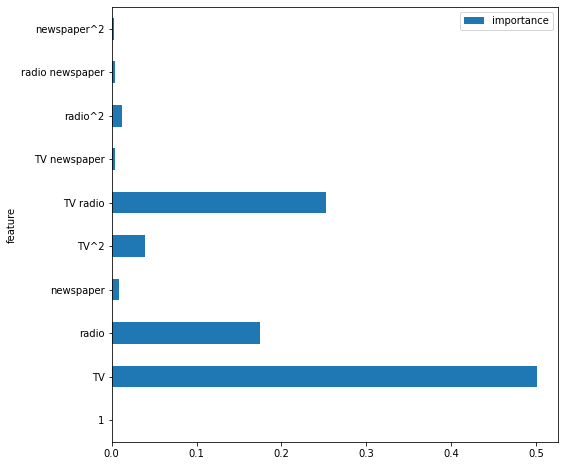

In [173]:
pd.DataFrame(data = zip(list(list(polynomial.get_feature_names_out(input_features = list(X.columns)))),list(rf_reg.feature_importances_)), columns = ['feature','importance']).plot.barh(y = 'importance',x= 'feature',figsize=(8,8),align = 'center')

### lets implement LightGBM

In [174]:
lgbm_reg = LGBMRegressor(random_state = 42)
param_grids = {'boosting_type':['gbdt','dart','goss','rf'],'max_depth' : [1,2,3,4],'learning_rate' : [0.1,1.0,0.01],'n_estimators':[36,34,35],'subsample': [0.8,0.6],'colsample_bytree': [0.3,0.4,0.5] ,'reg_alpha':[0.7,0.6],'reg_lambda':[0.1,0.0,0.2]}
lgbm_reg = GridSearchCV(estimator = lgbm_reg,param_grid = param_grids,cv = 5, scoring = 'neg_median_absolute_error', verbose = 2)
lgbm_reg.fit(X_train_poly,y_train)
lgbm_reg.best_estimator_

Streaming output truncated to the last 5000 lines.
[CV] END boosting_type=rf, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END boosting_type=rf, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END boosting_type=rf, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END boosting_type=rf, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END boosting_type=rf, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0, subsample=0.8; total time=   0.0s
[CV] END boosting_type=rf, colsample_bytree=0.3, learning_rate=0.01, max_depth=1, n_estimators=36, reg_alpha=0.6, reg_lambda=0.0,

LGBMRegressor(boosting_type='dart', colsample_bytree=0.5, learning_rate=1.0,
              max_depth=2, n_estimators=36, random_state=42, reg_alpha=0.7,
              reg_lambda=0.2, subsample=0.8)

In [175]:
lgbm_reg = LGBMRegressor(boosting_type='dart', colsample_bytree=0.5, learning_rate=1.0,max_depth=2, n_estimators=36, random_state=42, reg_alpha=0.7,reg_lambda=0.2, subsample=0.8)
lgbm_reg.fit(X_train_poly,y_train)
y_pred = lgbm_reg.predict(X_test_poly)
metrics(y_test,y_pred,model = 'LightGBM')
result_dataset

r2_score for LightGBM :0.9438987241656449
adjusted_r2_score for LightGBM :0.9158480862484674
median_absolute_error for LightGBM :0.5413455911596001
mean_squared_error for LightGBM :1.8014172265357509
mean_absolute_percentage_error for LightGBM :0.11988537285055809
mean_absolute_error for LightGBM :0.9219590667978194


,linear_regression,polynomial_linear_regression,lasso_regression,ridge_regression,elasticnet_regression,SVR,Decision_Tree,Random_Forest,LightGBM
r2_score,0.919034,0.983180,0.982735,0.983146,0.982720,0.861747,0.935422,0.979212,0.943899
adjusted_r2_score,0.878551,0.974770,0.974103,0.974719,0.974080,0.792621,0.903133,0.968818,0.915848
median_absolute_error,1.152449,0.371813,0.344593,0.371801,0.347960,0.629246,0.841667,0.562000,0.541346
mean_squared_error,2.599832,0.540101,0.554376,0.541189,0.554872,4.439317,2.073608,0.667510,1.801417
mean_absolute_percentage_error,0.149571,0.071710,0.072487,0.071811,0.072577,0.169369,0.129499,0.070787,0.119885
mean_absolute_error,1.308230,0.516803,0.516838,0.517371,0.517761,1.321750,1.104958,0.662100,0.921959


#### Lets Interpret the model

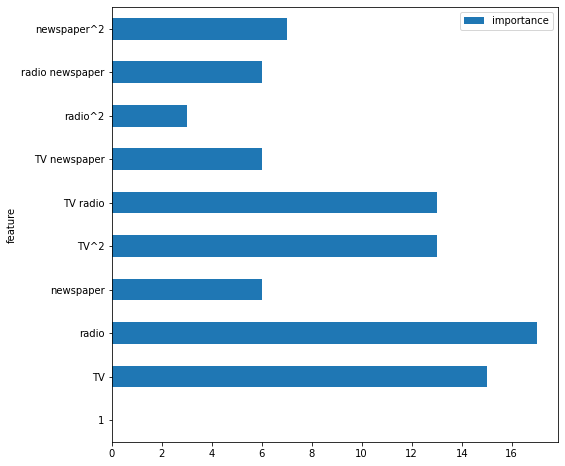

In [177]:
pd.DataFrame(data = zip(list(list(polynomial.get_feature_names_out(input_features = list(X.columns)))),list(lgbm_reg.feature_importances_)), columns = ['feature','importance']).plot.barh(y = 'importance',x= 'feature',figsize=(8,8),align = 'center')

# Now lets implement Lime and SHAP to get the model agnostic feature importances


### LIME

In [180]:
#! pip install lime
import lime
from lime import lime_tabular

In [181]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_poly, feature_names=list(list(polynomial.get_feature_names_out(input_features = list(X.columns)))), class_names=['sales'], categorical_features=None, verbose=True, mode='regression')

In [197]:
exp = explainer.explain_instance(data_row=X_test_poly[20,:],predict_fn=poly_linear_reg.predict)
exp.show_in_notebook(show_table=True)
print('Actual y_test is : ', np.array(y_test)[20])

Intercept 15.073489672826843
Prediction_local [12.09556267]
Right: 11.952382336450372


Actual y_test is :  [11.9]


In [206]:
pd.DataFrame(data = list(X_test_poly[20:21,:]), columns = list(list(polynomial.get_feature_names_out(input_features = list(X.columns)))))

,1,TV,radio,newspaper,TV^2,TV radio,TV newspaper,radio^2,radio newspaper,newspaper^2
0,1.0,-0.438752,-0.575709,-1.168264,0.192503,0.252593,0.512578,0.331441,0.67258,1.36484


observations:
* As per LIME our value decerased from max which is 27.31 as our spend on tv and radio is between the values shown above . that means as our test record have tv and radio spend  -0.438752	-0.575709 , total sales is reduced from the maximum, so it showed the negetive effect.



### SHAP

In [210]:
#! pip install shap
import shap
shap.initjs()

In [257]:
# Create object that can calculate shap values
explainer = shap.Explainer(poly_linear_reg,pd.DataFrame(data = X_train_poly, columns = list(list(polynomial.get_feature_names_out(input_features = list(X.columns))))))
# Calculate Shap values
shap_values = explainer(pd.DataFrame(data = X_test_poly, columns = list(list(polynomial.get_feature_names_out(input_features = list(X.columns))))))

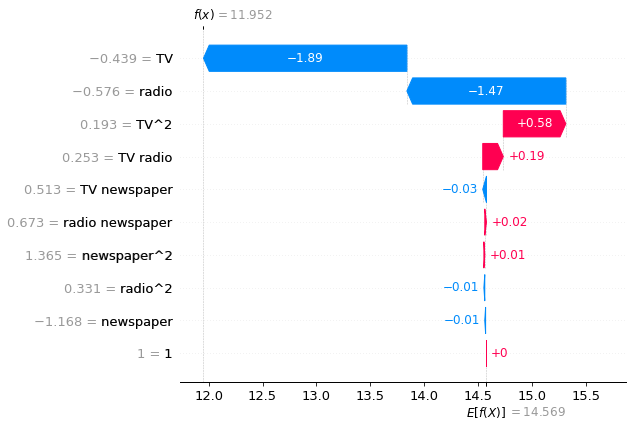

In [258]:
shap.plots.waterfall(shap_values[20])

observations:

We can see that LIME and SHAP are aggreing with the point because TV and radio values precdiction of that query point became low from the max value.